#### 队列

FIFO(First IN First OUT)

* 用数组实现的队列叫作顺序队列
* 用链表实现的队列叫作链式队列。

##### 应用
循环队列、阻塞队列、并发队列。

它们在很多偏底层系统、框架、中间件的开发中，起着关键性的作用。

比如高性能队列 Disruptor、Linux 环形缓存，都用到了循环并发队列；Java concurrent 并发包利用 ArrayBlockingQueue 来实现公平锁等。


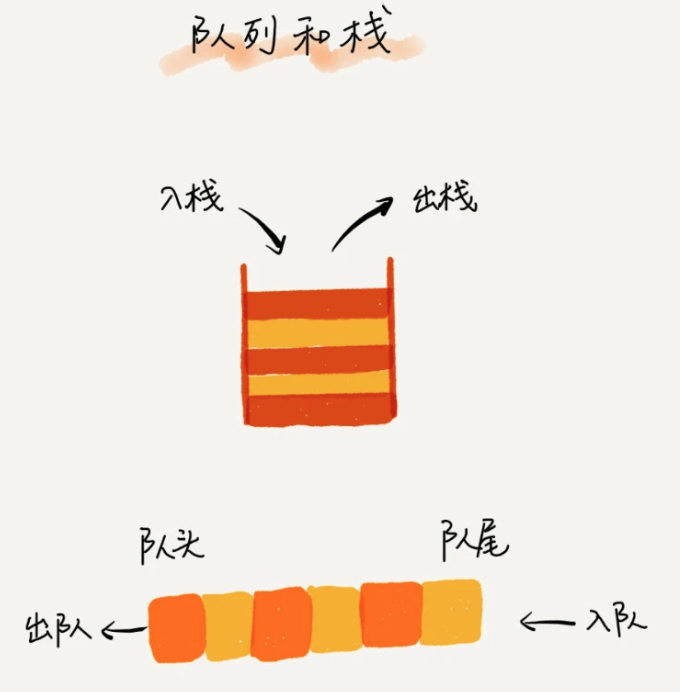


##### FAQ

线程池没有空闲线程时，新的任务请求线程资源时，线程池该如何处理？各种处理策略又是如何实现的呢？
* 第一种是非阻塞的处理方式，直接拒绝任务请求；
* 另一种是阻塞的处理方式，将请求排队，等到有空闲线程时，取出排队的请求继续处理


那如何存储排队的请求呢？
* 我们希望公平地处理每个排队的请求，先进者先服务，所以队列这种数据结构很适合来存储排队请求


队列有基于链表和基于数组这两种实现方式。这两种实现方式对于排队请求又有什么区别呢？
* 基于链表的实现方式，可以实现一个支持无限排队的无界队列（unbounded queue），但是可能会导致过多的请求排队等待，请求处理的响应时间过长。所以，针对响应时间比较敏感的系统，基于链表实现的无限排队的线程池是不合适的。
* 基于数组实现的有界队列（bounded queue），队列的大小有限，所以线程池中排队的请求超过队列大小时，接下来的请求就会被拒绝，这种方式对响应时间敏感的系统来说，就相对更加合理。不过，设置一个合理的队列大小，也是非常有讲究的。队列太大导致等待的请求太多，队列太小会导致无法充分利用系统资源、发挥最大性能。


除了前面讲到队列应用在`线程池请求排队`的场景之外，队列可以应用在任何有限资源池中，用于排队请求，比如`数据库连接池`等。实际上，对于大部分资源有限的场景，当没有空闲资源时，基本上都可以通过“队列”这种数据结构来实现请求排队。


##### 顺序队列时间复杂度

1. 入队 O(1)
2. 出队 O(n) -> O(1)
   1. 每次出队都进行数据迁移的话，每次都是O(n)
   2. 将数据迁移优化到入队时进行操作，只有在tail=n时，才需要进行数据迁移。迁移的时间复杂度为O(n)，平摊到每次操作上即为 O(1)

~~~
// 用数组实现的队列
public class ArrayQueue {
  // 数组：items，数组大小：n
  private String[] items;
  private int n = 0;
  // head表示队头下标，tail表示队尾下标
  private int head = 0;
  private int tail = 0;

  // 申请一个大小为capacity的数组
  public ArrayQueue(int capacity) {
    items = new String[capacity];
    n = capacity;
  }

  // 入队
  public boolean enqueue(String item) {
    // 如果tail == n 表示队列已经满了
    if (tail == n) return false;
    items[tail] = item;
    ++tail;
    return true;
  }

  // 出队
  public String dequeue() {
    // 如果head == tail 表示队列为空
    if (head == tail) return null;
    // 为了让其他语言的同学看的更加明确，把--操作放到单独一行来写了
    String ret = items[head];
    ++head;
    return ret;
  }
}
~~~


##### 数据迁移的优化

~~~

   // 入队操作，将item放入队尾
  public boolean enqueue(String item) {
    // tail == n表示队列末尾没有空间了
    if (tail == n) {
      // tail ==n && head==0，表示整个队列都占满了
      if (head == 0) return false;
      // 数据搬移
      for (int i = head; i < tail; ++i) {
        items[i-head] = items[i];
      }
      // 搬移完之后重新更新head和tail
      tail -= head;
      head = 0;
    }
    
    items[tail] = item;
    ++tail;
    return true;
  }
~~~

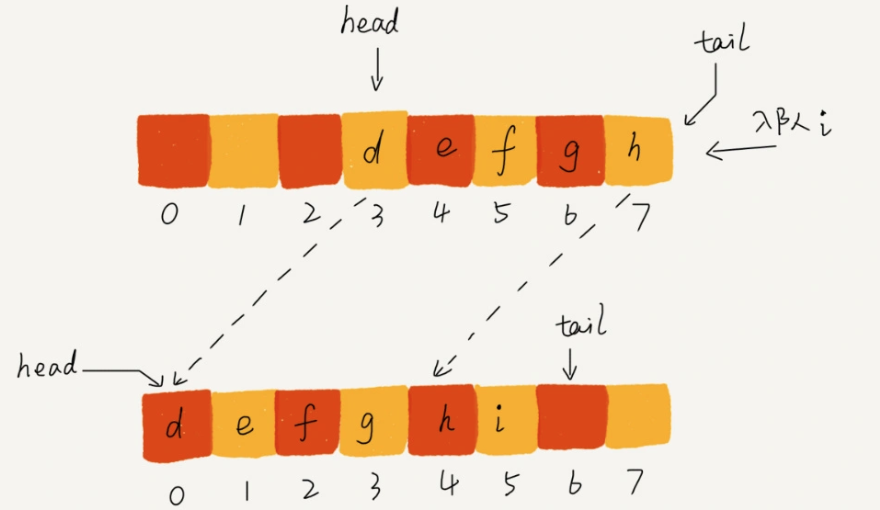

##### 循环队列

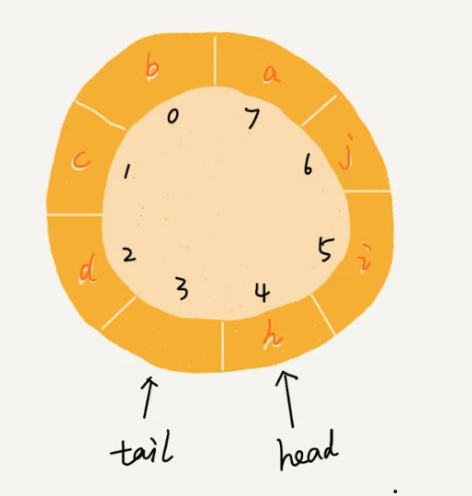

```
public class CircularQueue {
  // 数组：items，数组大小：n
  private String[] items;
  private int n = 0;
  // head表示队头下标，tail表示队尾下标
  private int head = 0;
  private int tail = 0;

  // 申请一个大小为capacity的数组
  public CircularQueue(int capacity) {
    items = new String[capacity];
    n = capacity;
  }

  // 入队
  public boolean enqueue(String item) {
    // 队列满了
    if ((tail + 1) % n == head) return false;
    items[tail] = item;
    tail = (tail + 1) % n;
    return true;
  }

  // 出队
  public String dequeue() {
    // 如果head == tail 表示队列为空
    if (head == tail) return null;
    String ret = items[head];
    head = (head + 1) % n;
    return ret;
  }
}
```



##### 阻塞队列

阻塞队列其实就是在队列基础上增加了阻塞操作。
简单来说，就是在队列为空的时候，从队头取数据会被阻塞
* 因为此时还没有数据可取，直到队列中有了数据才能返回；
* 如果队列已经满了，那么插入数据的操作就会被阻塞，直到队列中有空闲位置后再插入数据，然后再返回。

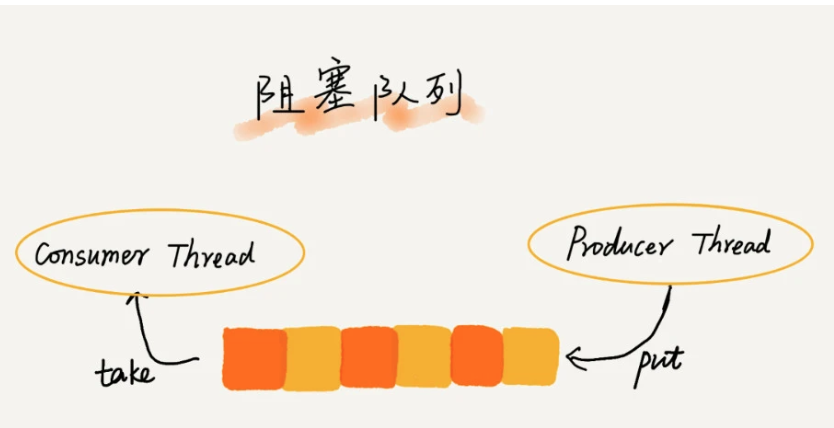

一个“生产者 - 消费者模型”

种基于阻塞队列实现的“生产者 - 消费者模型”，可以有效地协调生产和消费的速度。当“生产者”生产数据的速度过快，“消费者”来不及消费时，存储数据的队列很快就会满了。这个时候，生产者就阻塞等待，直到“消费者”消费了数据，“生产者”才会被唤醒继续“生产”。

而且不仅如此，基于阻塞队列，我们还可以通过协调“生产者”和“消费者”的个数，来提高数据的处理效率。比如前面的例子，我们可以多配置几个“消费者”，来应对一个“生产者”。

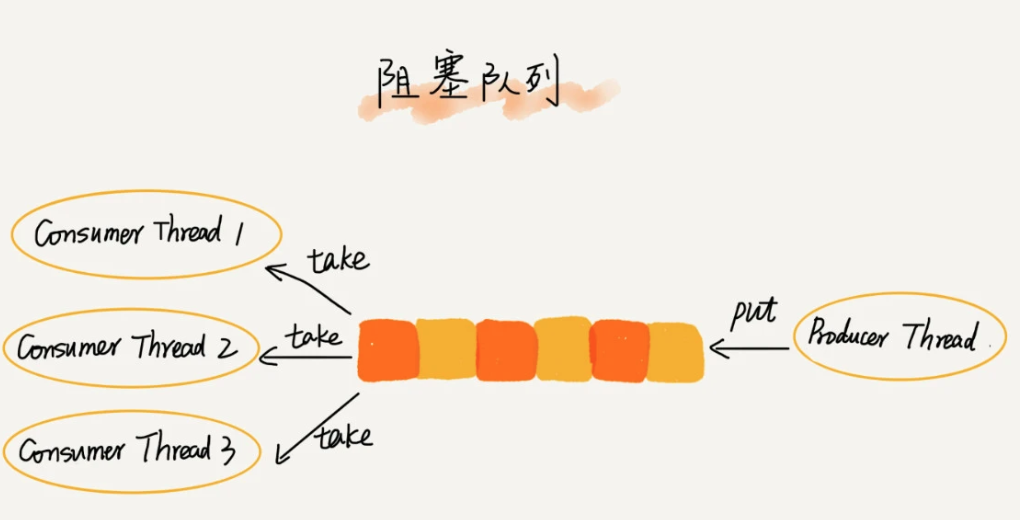




##### 并发队列

面我们讲了阻塞队列，在多线程情况下，会有多个线程同时操作队列，这个时候就会存在线程安全问题，那如何实现一个线程安全的队列呢？

线程安全的队列我们叫作并发队列。
* 最简单直接的实现方式是直接在 enqueue()、dequeue() 方法上加锁
* 但是锁粒度大并发度会比较低
* 同一时刻仅允许一个存或者取操作。
* 实际上，基于数组的循环队列，利用 CAS 原子操作，可以实现非常高效的并发队列。这也是循环队列比链式队列应用更加广泛的原因。
在实战篇讲 Disruptor 的时候，我会再详细讲并发队列的应



In [ ]:
'''
leetcode meduin

641 design circular deque

Design your implementation of the circular double-ended queue (deque).

Implement the MyCircularDeque class:

MyCircularDeque(int k) Initializes the deque with a maximum size of k.
boolean insertFront() Adds an item at the front of Deque. Returns true if the operation is successful, or false otherwise.
boolean insertLast() Adds an item at the rear of Deque. Returns true if the operation is successful, or false otherwise.
boolean deleteFront() Deletes an item from the front of Deque. Returns true if the operation is successful, or false otherwise.
boolean deleteLast() Deletes an item from the rear of Deque. Returns true if the operation is successful, or false otherwise.
int getFront() Returns the front item from the Deque. Returns -1 if the deque is empty.
int getRear() Returns the last item from Deque. Returns -1 if the deque is empty.
boolean isEmpty() Returns true if the deque is empty, or false otherwise.
boolean isFull() Returns true if the deque is full, or false otherwise.
'''

class MyCircularDeque:
    
    def __init__(self, k: int):
        self.cap = k
        self.queue = []
        

    def insertFront(self, value: int) -> bool:
        if len(self.queue) == self.cap:
            return False
        self.queue.insert(0, value)
        return True
        

    def insertLast(self, value: int) -> bool:
        if len(self.queue) == self.cap:
            return False
        self.queue.insert(len(self.queue), value)
        return True

        

    def deleteFront(self) -> bool:
        if len(self.queue) == 0:
            return False
        del self.queue[0]
        return True
        

    def deleteLast(self) -> bool:
        if len(self.queue) == 0:
            return False
        del self.queue[len(self.queue)-1]
        return True
        

    def getFront(self) -> int:
        if len(self.queue) == 0:
            return -1
        return self.queue[0]
        

    def getRear(self) -> int:
        if len(self.queue) == 0:
            return -1
        return self.queue[len(self.queue)-1]
        

    def isEmpty(self) -> bool:
        return False if self.queue else True
        

    def isFull(self) -> bool:
        return True if len(self.queue) == self.cap else False
        


# Your MyCircularDeque object will be instantiated and called as such:
# obj = MyCircularDeque(k)
# param_1 = obj.insertFront(value)
# param_2 = obj.insertLast(value)
# param_3 = obj.deleteFront()
# param_4 = obj.deleteLast()
# param_5 = obj.getFront()
# param_6 = obj.getRear()
# param_7 = obj.isEmpty()
# param_8 = obj.isFull()

In [ ]:
'''
239. Sliding Window Maximum Hard

You are given an array of integers nums, there is a sliding window of size k which is moving from the very left of the array to the very right. You can only see the k numbers in the window. Each time the sliding window moves right by one position.

Return the max sliding window

Example 1:

Input: nums = [1,3,-1,-3,5,3,6,7], k = 3
Output: [3,3,5,5,6,7]
Explanation: 
Window position                Max
---------------               -----
[1  3  -1] -3  5  3  6  7       3
 1 [3  -1  -3] 5  3  6  7       3
 1  3 [-1  -3  5] 3  6  7       5
 1  3  -1 [-3  5  3] 6  7       5
 1  3  -1  -3 [5  3  6] 7       6
 1  3  -1  -3  5 [3  6  7]      7
'''

class Solution:
    def maxSlidingWindow(self, nums: List[int], k: int) -> List[int]:
        if not nums:
            return []

        # ** window 存的是下标，window[0] 在当前窗口下的最大值的下标
        window, res = [], []

        # nums = [1,3,-1,-3,5,3,6,7], k = 3
        for i, x in enumerate(nums):
            # step3: i=3, 要在[1, 3,-1,-3...] 中[3,-1,-3]里判断最大值，如果 w[0] <= (i-k=0), 则需要把 w最左的索引去掉
            # ** 最大数据的索引 滑出窗口了，需要pop
            if i >= k and window[0] <= i-k:
                window.pop(0)        
            # step0: i=0, x=1, w 为空
            # step1: i=1, x=3, n[w[-1]]=n[0]=1 <= 3, 对 n的[1,3]来说，1就不需要了-> w=[]
            # step2: i=2, x=-1,n[w[-1]]=n[1]=3 > -1
            # ** window 从后往前的数据中，如果比当前小，则当前数据滑出窗口前，前面小的数据不需要再考虑，直接pop
            while window and nums[window[-1]] <= x:
                window.pop()

            # step0: w=[0]
            # step1: w=[1]
            # step2: w=[1,2]
            window.append(i)
            # step2: i=3, w=[1,2]
            if i >= k-1:
                res.append(nums[window[0]])
            
        return res